In [18]:
import scanpy as sc
import pandas as pd
import rna_seq_functions as rna
import anndata as ad
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import json

In [63]:
experiment_data_dir = '/Users/akre96/Data/HSC_aging_project/serial_transplant/rna_seq/experiments/bridged'
replicates = ['AN6', 'AN7']
gene_list_dir = '/Users/akre96/Data/HSC_aging_project/serial_transplant/rna_seq/filtered_gene_lists'
abundance_data_path = '/Users/akre96/Data/HSC_aging_project/serial_transplant/Ania_M_allAnia serial rerunserial_Ania_percent-engraftment_NO filter_080919_long.csv'
#percent_cell_threshold = .5
#umi_threshold = 2
#gene_set_length = 3566

#umi_threshold = 3
#gene_set_length = 2156

percent_cell_threshold = 0.5
umi_threshold = 50
gene_set_length = 114

gene_list_file_name = os.path.join(
    gene_list_dir,
    'filtered_gene-list_pcells-' \
    + str(percent_cell_threshold) \
    + '_umicount-' + str(umi_threshold) \
    + '_len-' + str(gene_set_length) + '.npy'
)


In [64]:
filtered_gene_list = rna.filtered_numpy_gene_list(gene_list_file_name).gene_id.tolist()
abundance_data = pd.read_csv(abundance_data_path)
last_abundance_data = abundance_data[abundance_data.day == 142]
piv_abundance = last_abundance_data.pivot_table(
    values='percent_engraftment',
    columns=['cell_type'],
    index=['code', 'mouse_id', 'group'],
    fill_value=0,
).reset_index().rename(columns={'code': 'TBC'})
piv_abundance.head()

cell_type,TBC,mouse_id,group,b,gr,hsc
0,AAGCTAAAAAAAGTGTAAGGAACAGTGCGTGGAAGATCGGAAGAGC...,M3,aging_phenotype,0.0,0.0,0.0
1,AAGCTAAAAACATCGCCTAGTGGAAGACAATTAAGATCGGAAGAGC...,M3,aging_phenotype,0.0,0.0,0.0
2,AAGCTAAAAAGGCGTCGAATTTGTGGTGTATTGAGATCGGAAGAGC...,M3,aging_phenotype,0.0,0.0,0.0
3,AAGCTAAAAAGTAAGGGATACTGGTGAAAATTATAGATCGGAAGAG...,M3,aging_phenotype,0.0,0.0,0.0
4,AAGCTAAAACACGAGCGCGAGTTGTCCCCTTCAAGATCGGAAGAGC...,M3,aging_phenotype,0.0,0.0,0.0


In [65]:
dfs = []
for replicate in replicates:
    wide_data = pd.read_csv(os.path.join(experiment_data_dir, replicate + '_bridged.csv'))
    wide_data = wide_data[wide_data.TBC != 'CTTATGATCGATATTTGCGTCTGCGGCGTAGTCAGATCGGAAGAGCTCGT']

    wide_data['replicate'] = replicate
    wide_data = wide_data.merge(
        piv_abundance,
        how='left',
        validate='m:1',
        on='TBC'
    )
    dfs.append(wide_data)

comb_df = pd.concat(dfs)    
rep_ann = ad.AnnData(
    X=comb_df[['CBC'] + filtered_gene_list].set_index('CBC'),
    obs=comb_df[['CBC', 'TBC', 'replicate', 'mouse_id', 'group', 'b', 'gr', 'hsc']].set_index('CBC'),
)


/Users/akre96/Documents/github/stemcell_aging/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [66]:
rep_ann.obs.groupby(['TBC', 'mouse_id', 'replicate']).count().sort_values(by='group', ascending=False)

,,,group,b,gr,hsc
TBC,mouse_id,replicate,,,,
ATGACAAACGAGTGGAGCATCCGAGTTGATGTAGATCGGAAGAGCTCGTA,M6,AN6,85,85,85,85
GAGTTCACCGACGCACGGGGGCGACAGCACTCGAGATCGGAAGAGCTCGT,M12,AN6,38,38,38,38
ATGACATCCGGTCATGCGGCTTCCGCCGCCCTCAGATCGGAAGAGCTCGT,M6,AN6,32,32,32,32
ATGACAAACGAGTGGAGCATCCGAGTTGATGTAGATCGGAAGAGCTCGTA,M6,AN7,25,25,25,25
GAGTTCTAGGTGCTTTCGGGGGTTAACTCCAGTAGATCGGAAGAGCTCGT,M12,AN6,15,15,15,15
GAGTTCACCGACGCACGGGGGCGACAGCACTCGAGATCGGAAGAGCTCGT,M12,AN7,14,14,14,14
ATGACAGTCGTCGGCTTACCATCATTCCCACGCCAGACGGAAGAGCTCGT,M6,AN6,13,13,13,13
ATGACATCCGGTCATGCGGCTTCCGCCGCCCTCAGATCGGAAGAGCTCGT,M6,AN7,10,10,10,10
GAGTTCTAGGTGCTTTCGGGGGTTAACTCCAGTAGATCGGAAGAGCTCGT,M12,AN7,8,8,8,8


... storing 'TBC' as categorical
... storing 'replicate' as categorical
... storing 'mouse_id' as categorical
... storing 'group' as categorical


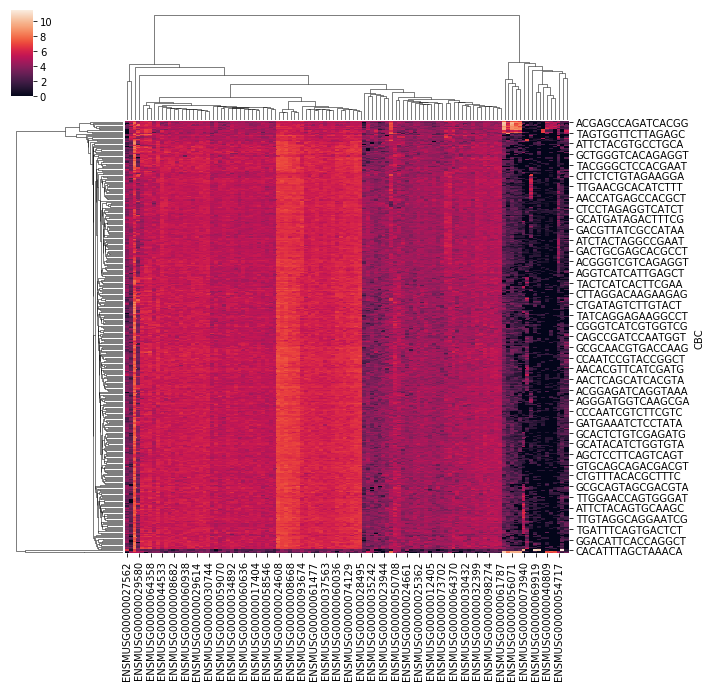

In [67]:
mpl.rcParams['font.size'] = 10
sc.pl.clustermap(rep_ann)

In [68]:
sc.tl.tsne(rep_ann, use_rep='X')

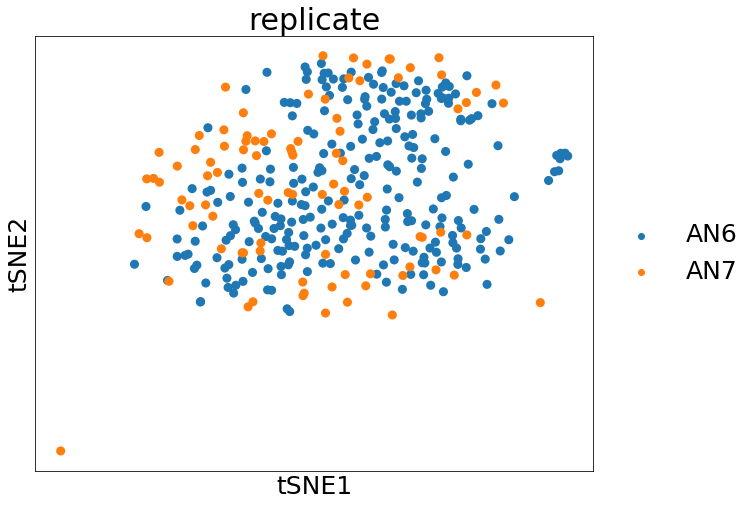

In [69]:
mpl.rcParams['font.size'] = 25
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.tsne(rep_ann, ax=ax, color='replicate')


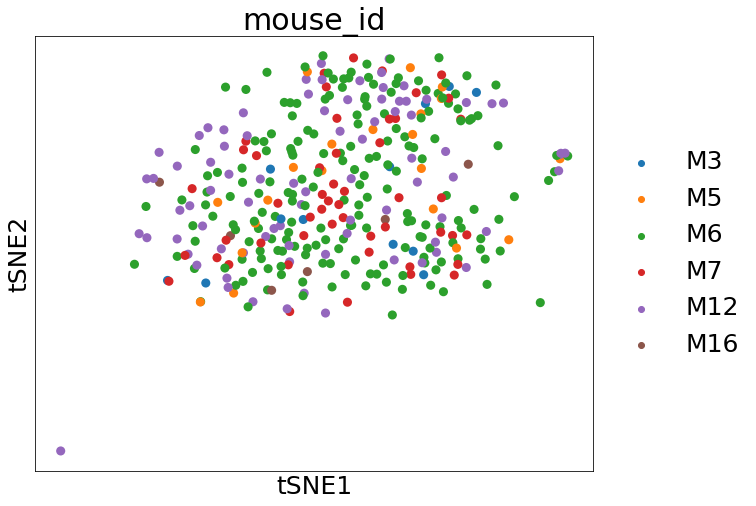

In [70]:
mpl.rcParams['font.size'] = 25
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.tsne(rep_ann, ax=ax, color='mouse_id')


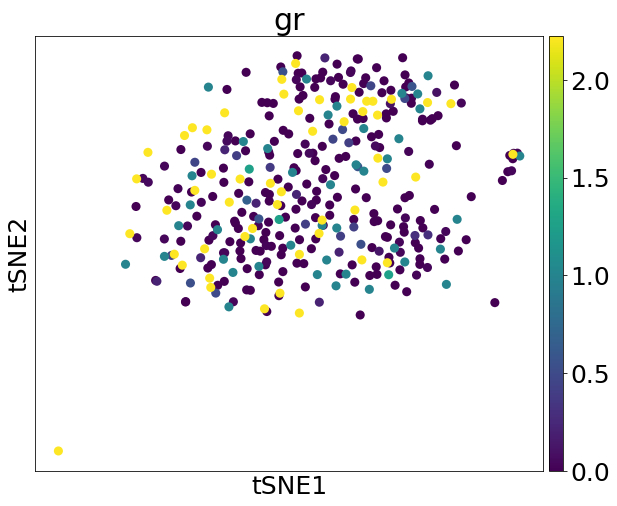

In [71]:
mpl.rcParams['font.size'] = 25
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.tsne(rep_ann, ax=ax, color='gr')

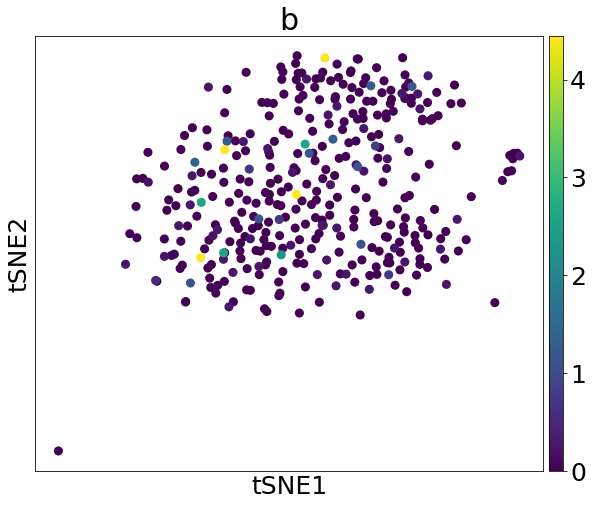

In [72]:
mpl.rcParams['font.size'] = 25
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.tsne(rep_ann, ax=ax, color='b')

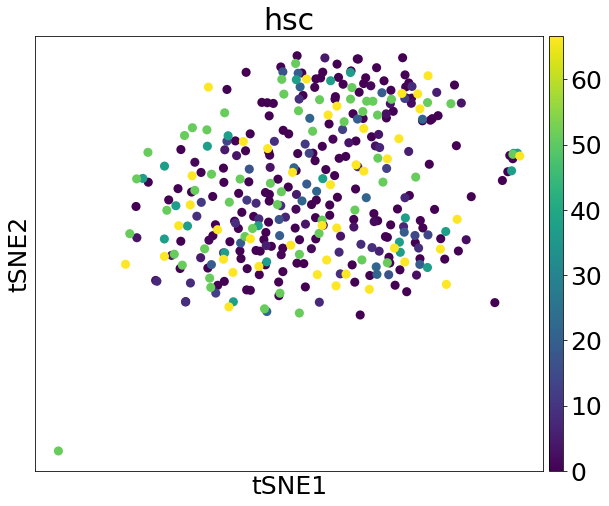

In [73]:
mpl.rcParams['font.size'] = 25
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.tsne(rep_ann, ax=ax, color='hsc')